# LangChain 核心模块学习：Chains

对于简单的大模型应用，单独使用语言模型（LLMs）是可以的。

**但更复杂的大模型应用需要将 `LLMs` 和 `Chat Models` 链接在一起 - 要么彼此链接，要么与其他组件链接。**

LangChain 为这种“链式”应用程序提供了 `Chain` 接口。

LangChain 以通用方式定义了 `Chain`，它是对组件进行调用序列的集合，其中可以包含其他链。

In [5]:
! pip install -U langchain

## LLMChain

LLMChain 是 LangChain 中最简单的链，作为其他复杂 Chains 和 Agents 的内部调用，被广泛应用。

一个LLMChain由PromptTemplate和语言模型（LLM or Chat Model）组成。它使用直接传入（或 memory 提供）的 key-value 来规范化生成 Prompt Template（提示模板），并将生成的 prompt （格式化后的字符串）传递给大模型，并返回大模型输出。

![](../images/llm_chain.png)

## Router Chain: 实现条件判断的大模型调用


这段代码构建了一个可定制的链路系统，用户可以提供不同的输入提示，并根据这些提示获取适当的响应。

主要逻辑：从`prompt_infos`创建多个`LLMChain`对象，并将它们保存在一个字典中，然后创建一个默认的`ConversationChain`，最后创建一个带有路由功能的`MultiPromptChain`。

![](../images/router_chain.png)

In [6]:
from langchain.chains.router import MultiPromptChain
from langchain_openai import OpenAI
from langchain.chains import ConversationChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate

In [7]:
physics_template = """你是一位非常聪明的物理教授。
你擅长以简洁易懂的方式回答关于物理的问题。
当你不知道某个问题的答案时，你会坦诚承认。

这是一个问题：
{input}"""


math_template = """你是一位很棒的数学家。你擅长回答数学问题。
之所以如此出色，是因为你能够将难题分解成各个组成部分，
先回答这些组成部分，然后再将它们整合起来回答更广泛的问题。

这是一个问题：
{input}"""

biology_template = """你是一位资深的生物学专家。
你对生物学的各个分支都有深入的了解，能够清晰地解释复杂的生物学概念。
当面对超出你知识范围的问题时，你会诚实地表示需要进一步研究。

这是一个问题：
{input}"""

chinese_language_template = """你是一位博学的汉语言文学教授。
你对汉语的语言学、文学和历史有着丰富的知识，能够详细解读古今中外的文学作品。
如果遇到自己不熟悉的文学领域或作品时，你会保持学者的谦逊态度。

这是一个问题：
{input}"""

computer_science_template = """你是一位经验丰富的计算机科学家。
你精通编程、算法、数据结构以及最新的技术趋势，可以提供深入的技术解答和建议。
当遇到尚未解决的技术难题时，你会积极寻找答案或提出可能的解决方案。

这是一个问题：
{input}"""

In [8]:
prompt_infos = [
    {
        "name": "物理",
        "description": "适用于回答物理问题",
        "prompt_template": physics_template
    },
    {
        "name": "数学",
        "description": "适用于回答数学问题",
        "prompt_template": math_template
    },
    {
        "name": "生物",
        "description": "适用于回答生物学问题",
        "prompt_template": biology_template
    },
    {
        "name": "汉语言",
        "description": "适用于回答关于汉语言文学的问题",
        "prompt_template": chinese_language_template
    },
    {
        "name": "计算机",
        "description": "适用于回答计算机科学问题",
        "prompt_template": computer_science_template
    },
]

In [9]:
llm = OpenAI(model_name="gpt-3.5-turbo-instruct")

In [10]:
# 创建一个空的目标链字典，用于存放根据prompt_infos生成的LLMChain。
destination_chains = {}

# 遍历prompt_infos列表，为每个信息创建一个LLMChain。
for p_info in prompt_infos:
    name = p_info["name"]  # 提取名称
    prompt_template = p_info["prompt_template"]  # 提取模板
    # 创建PromptTemplate对象
    prompt = PromptTemplate(template=prompt_template, input_variables=["input"])
    # 使用上述模板和llm对象创建LLMChain对象
    chain = LLMChain(llm=llm, prompt=prompt)
    # 将新创建的chain对象添加到destination_chains字典中
    destination_chains[name] = chain

# 创建一个默认的ConversationChain
default_chain = ConversationChain(llm=llm, output_key="text")

/root/miniconda3/envs/langchain/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
/root/miniconda3/envs/langchain/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ConversationChain` was deprecated in LangChain 0.2.7 and will be removed in 1.0. Use RunnableWithMessageHistory: https://api.python.langchain.com/en/latest/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html instead.
  warn_deprecated(


In [11]:
type(default_chain)

langchain.chains.conversation.base.ConversationChain

### 使用 LLMRouterChain 实现条件判断调用

这段代码定义了一个chain对象（LLMRouterChain），该对象首先使用router_chain来决定哪个destination_chain应该被执行，如果没有合适的目标链，则默认使用default_chain。

In [12]:
from langchain.chains.router.llm_router import LLMRouterChain, RouterOutputParser
from langchain.chains.router.multi_prompt_prompt import MULTI_PROMPT_ROUTER_TEMPLATE

In [13]:
# 从prompt_infos中提取目标信息并将其转化为字符串列表
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
# 使用join方法将列表转化为字符串，每个元素之间用换行符分隔
destinations_str = "\n".join(destinations)
# 根据MULTI_PROMPT_ROUTER_TEMPLATE格式化字符串和destinations_str创建路由模板
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(destinations=destinations_str)
# 创建路由的PromptTemplate
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)
# 使用上述路由模板和llm对象创建LLMRouterChain对象
router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [14]:
print(destinations)

['物理: 适用于回答物理问题', '数学: 适用于回答数学问题', '生物: 适用于回答生物学问题', '汉语言: 适用于回答关于汉语言文学的问题', '计算机: 适用于回答计算机科学问题']


In [15]:
print(destinations_str)

物理: 适用于回答物理问题
数学: 适用于回答数学问题
生物: 适用于回答生物学问题
汉语言: 适用于回答关于汉语言文学的问题
计算机: 适用于回答计算机科学问题


In [16]:
print(MULTI_PROMPT_ROUTER_TEMPLATE)

Given a raw text input to a language model select the model prompt best suited for the input. You will be given the names of the available prompts and a description of what the prompt is best suited for. You may also revise the original input if you think that revising it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt names specified below OR it can be "DEFAULT" if the input is not well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (must include ```json at the start of the respon

In [17]:
print(router_template)

Given a raw text input to a language model select the model prompt best suited for the input. You will be given the names of the available prompts and a description of what the prompt is best suited for. You may also revise the original input if you think that revising it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}
```

REMEMBER: "destination" MUST be one of the candidate prompt names specified below OR it can be "DEFAULT" if the input is not well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
物理: 适用于回答物理问题
数学: 适用于回答数学问题
生物: 适用于回答生物学问题
汉语言: 适用于回答关于汉语言文学的问题
计算机: 适用于回答计算机科学问题

<< INPUT >>
{input

In [18]:
# 创建MultiPromptChain对象，其中包含了路由链，目标链和默认链。
chain = MultiPromptChain(
    router_chain=router_chain,
    destination_chains=destination_chains,
    default_chain=default_chain,
    verbose=True,
)

In [19]:
print(chain.invoke("黑体辐射是什么？?"))



> Entering new MultiPromptChain chain...
物理: {'input': '黑体辐射是什么？?'}
> Finished chain.
{'input': '黑体辐射是什么？?', 'text': '\n\n黑体辐射是指处于热平衡状态下的理想化物体所发出的电磁辐射。它的特点是发射出的电磁波谱和温度成正比，且具有连续的频谱。黑体辐射是物理学中重要的概念，可以用来解释许多现象，比如太阳的辐射、宇宙微波背景辐射等。'}


In [20]:
print(
    chain.invoke(
        "大于40的第一个质数是多少，使得这个质数加一能被3整除？"
    )
)



> Entering new MultiPromptChain chain...
数学: {'input': '大于40的第一个质数是多少，使得这个质数加一能被3整除？'}
> Finished chain.
{'input': '大于40的第一个质数是多少，使得这个质数加一能被3整除？', 'text': '\n\n这个问题可以分解成两个部分：\n1. 大于40的第一个质数是什么？\n2. 这个质数加一能被3整除吗？\n\n首先回答第一个问题，我们可以列出大于40的质数列表：41、43、47、53、59、61、67、71、73、79、83、89、97。所以大于40的第一个质数是41。\n\n接着回答第二个问题，41加一是42，42除以3余数是0，所以42能被3整除。因此，41加一能被3整除。\n\n综合以上两个答案，大于40的第一个质数是41，使得这个质数加一能被3整除。'}


In [21]:
router_chain.verbose = True

In [23]:
print(chain.invoke("黑洞是什么？"))



> Entering new MultiPromptChain chain...


> Entering new LLMRouterChain chain...

> Finished chain.
物理: {'input': '物理问题是什么？'}
> Finished chain.
{'input': '物理问题是什么？', 'text': '\n\n物理问题是指与物理学相关的任何疑问、困惑或挑战。它可以涉及物质的性质、运动、力学、能量、电磁学、量子力学等方面。物理问题也可以是关于宇宙、自然现象和科学原理的探究。'}


### Homework

#### 扩展 Demo：实现生物、计算机和汉语言文学老师 PromptTemplates 及对应 Chains

In [24]:
print(chain.invoke("光合作用主要发生在植物的哪个细胞器中？"))



> Entering new MultiPromptChain chain...


> Entering new LLMRouterChain chain...

> Finished chain.
生物: {'input': '光合作用主要发生在植物的哪个细胞器中？'}
> Finished chain.
{'input': '光合作用主要发生在植物的哪个细胞器中？', 'text': '\n\n光合作用主要发生在植物的叶绿体中。'}


In [25]:
print(chain.invoke("汉语中的“四声”分别指的是哪四种声调？"))



> Entering new MultiPromptChain chain...


> Entering new LLMRouterChain chain...

> Finished chain.
汉语言: {'input': '汉语中的“四声”分别指的是哪四种声调？'}
> Finished chain.
{'input': '汉语中的“四声”分别指的是哪四种声调？', 'text': '\n\n答：汉语中的“四声”分别指的是平声、上声、去声和入声。平声是指声调平稳，没有升降的声调；上声是指声调从低到高升高的声调；去声是指声调从高到低降低的声调；入声是指声调从低到高然后又降低的声调。这四种声调在汉语中具有重要的区别作用，对于正确的发音和理解词语意思都有重要影响。'}


In [27]:
print(chain.invoke("TCP和UDP谢意主要有哪些区别？"))



> Entering new MultiPromptChain chain...


> Entering new LLMRouterChain chain...

> Finished chain.
计算机: {'input': 'TCP和UDP两者有什么不同？'}
> Finished chain.
{'input': 'TCP和UDP两者有什么不同？', 'text': '\n\nTCP（传输控制协议）和UDP（用户数据报协议）都是互联网中常用的传输协议，它们之间有以下几个不同点：\n\n1. 连接方式不同：\nTCP是一种面向连接的协议，传输数据前需要先建立连接，然后再发送数据。而UDP是一种无连接的协议，数据发送前不需要建立连接。\n\n2. 数据可靠性不同：\nTCP提供可靠的数据传输，保证数据的完整性和顺序，确保数据的正确性。UDP不提供可靠性保证，数据可能会丢失或者乱序，但是传输速度更快。\n\n3. 传输效率不同：\n由于TCP建立连接和保证数据可靠性的过程，会增加一定的传输开销，因此传输效率比UDP低。\n\n4. 应用场景不同：\nTCP适用于要求数据传输可靠'}



#### 总结：MULTI_PROMPT_ROUTER_TEMPLATE这个模板定义了模型输出的格式，以及在特定情况下（例如输入的描述不清晰）可以帮助修改输入的内容，用于获取更好的回答，所以在一次问答中会发送两次请求给大模型，第一次请求模型返回这个问题合适的类别以及优化的问题描述（或者保持原问题描述），第二次再把问题以及所属类别的提示词一起发送过去获取结果。

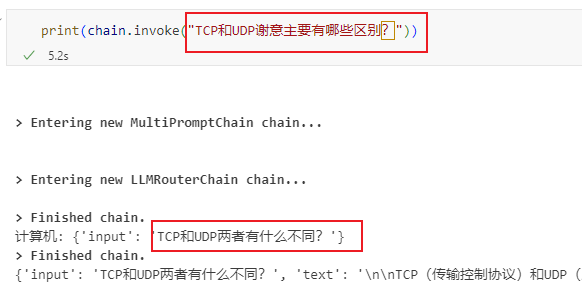